A popular example for image classification is the MNIST dataset, which contains digits from 0 to 9 in different styles. Here we'll use a drop-in replacement, called the fashion-mnist, consisting of different pieces of clothing. We can get the dataset directly via a keras utility function.

Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples (https://github.com/zalandoresearch/fashion-mnist).

In [1]:
from tensorflow import keras

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [3]:
import tensorflow as tf

In [4]:
import numpy as np

In [5]:
from matplotlib import pyplot as plt

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
train_images.shape

(60000, 28, 28)

In [8]:
test_images.shape

(10000, 28, 28)

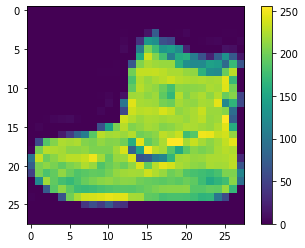

In [13]:
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

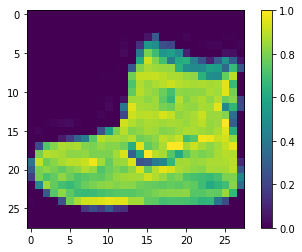

In [15]:
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

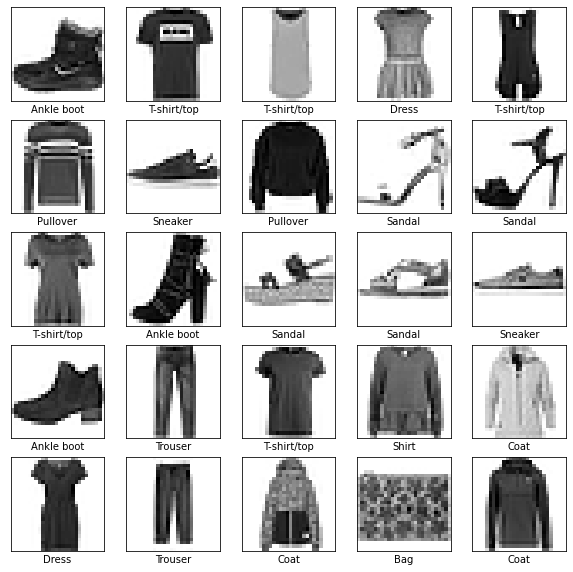

In [16]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [17]:
pip install scikit-image

In [10]:
import skimage.transform

def get_pyramid_features(img):
    return np.hstack([
        layer.reshape(-1)
        for layer in skimage.transform.pyramids.pyramid_gaussian(img)
    ])

In [11]:
from skimage import data, feature, exposure

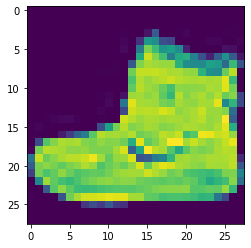

In [20]:
plt.imshow(train_images[0])

-0.20447270138324025 0.0993683816955817
-0.21556082223199366 0.042726124349179974
-0.09428870469466712 -0.014654777734303834
-0.03023575252106837 -0.019981221057295676


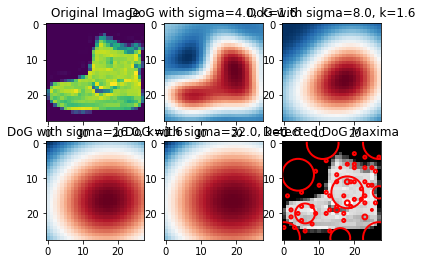

In [21]:
from skimage import data, feature, color, filters, img_as_float
from matplotlib import pyplot as plt


original_image = img_as_float(train_images[0])
img = color.rgb2gray(original_image)

k = 1.6

plt.subplot(2,3,1)
plt.imshow(original_image)
plt.title('Original Image')


sigmas = np.array([4.0, 8.0, 16.0, 32.0])
for idx, sigma in enumerate(sigmas):
    s1 = filters.gaussian(img,k*sigma)
    s2 = filters.gaussian(img,sigma)

    # multiply by sigma to get scale invariance
    dog = s1 - s2
    plt.subplot(2,3,idx+2)
    print(dog.min(),dog.max())
    plt.imshow(dog,cmap='RdBu')
    plt.title('DoG with sigma=' + str(sigma) + ', k=' + str(k))

ax = plt.subplot(2,3,6)

def blobify(img):
    blobs_dog = [
        (x[0], x[1], x[2])
        for x in feature.blob_dog(
            img, min_sigma=1e-12, max_sigma=5, threshold=0.0001, overlap=1.0
        )
    ]
    blobs_dog += [
        (x[0], x[1],x[2])
        for x in feature.blob_dog(
            -img, min_sigma=1e-12, max_sigma=5, threshold=0.0001, overlap=1.0
        )
    ]
    return blobs_dog


img_blobs = color.gray2rgb(img)
for blob in blobify(img):
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
plt.imshow(img_blobs)
plt.title('Detected DoG Maxima')

plt.show()


In [22]:
import numpy as np
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
import time

print(time.asctime( time.localtime(time.time()) ))
start_time = time.time()

def featurize(x_train, y_train):
    data = []
    labels = []
    for img, label in tqdm(zip(x_train, y_train)):
        data.append(get_pyramid_features(img))
        labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

x_tra, y_tra = featurize(train_images, train_labels)
clf = LinearSVC(C=1, loss='hinge').fit(x_tra, y_tra)

x_val, y_val = featurize(test_images, test_labels)
print('accuracy: {:.3f}'.format(clf.score(x_val, y_val)))


end_time = time.time()
print("Execution Time: ", int(end_time - start_time),'s')

Sat Jun 27 20:22:48 2020


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



accuracy: 0.840
Execution Time:  532 s


please see documentation at https://scikit-image.org/docs/0.8.0/api/skimage.transform.pyramids.html#id2

you can see wikipedia for more details: https://en.wikipedia.org/wiki/Scale_space

In [4]:
# https://en.wikipedia.org/wiki/LeNet

In [8]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

def compile_model(model):
    model.summary()
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )    

def create_mlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    compile_model(model)
    return model


def create_lenet():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', input_shape=(28, 28, 1), activation='tanh'),  # C1
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh'),  # C3
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='tanh'),
        tf.keras.layers.Dense(84, activation='tanh'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    compile_model(model)
    return model

In [10]:
model = create_mlp()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [9]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib
import seaborn as sns
import pandas as pd

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('figure', figsize=(10, 10))
np.set_printoptions(precision=2)
matplotlib.rc('font', **font)

def show_result(model, test_images):
    predictions = model.predict(test_images).argmax(axis=1)
    print(classification_report(test_labels, predictions, target_names=class_names))
    cm = confusion_matrix(test_labels, predictions, normalize='pred')
    sns.heatmap(
        pd.DataFrame(cm, columns=class_names, index=class_names),
        annot=True,
        cmap='Blues',
        fmt='.2f'
    )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
def train_model(model, train_images, test_images):
    model.fit(
        train_images,
        train_labels,
        epochs=50,
        verbose=1,
        validation_data=(test_images, test_labels)
    )
    loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print('loss:', loss)
    print('accuracy:', accuracy)
    show_result(model, test_images)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4980 - accuracy: 0.8265 - val_loss: 0.4393 - val_accuracy: 0.8430
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3728 - accuracy: 0.8655 - val_loss: 0.4091 - val_accuracy: 0.8519
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3369 - accur

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.80      0.79      0.80      1000
       Dress       0.88      0.89      0.88      1000
        Coat       0.78      0.85      0.81      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.74      0.66      0.70      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



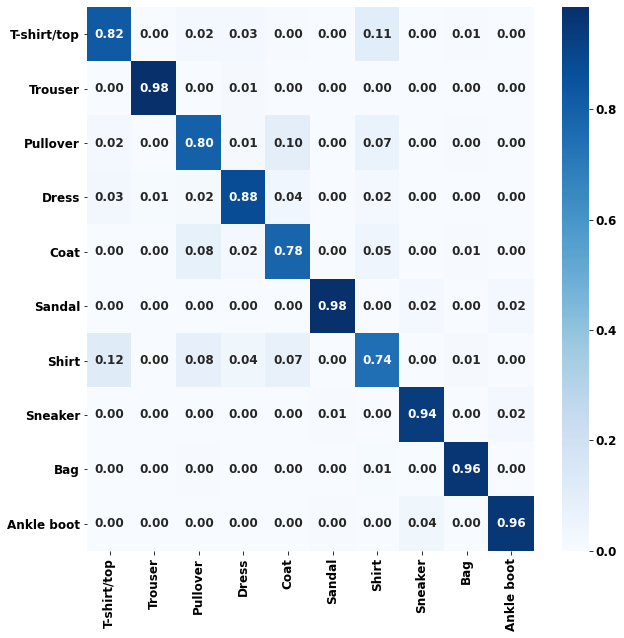

In [17]:
train_model(create_mlp(), train_images, test_images)

In [ ]:
train_model(
    create_lenet(),
    train_images.reshape(train_images.shape + (1,)),
    test_images.reshape(test_images.shape + (1,)),
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [13]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

doesn't include the classification layers

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [42]:
tf.config.experimental_run_functions_eagerly(True)

In [11]:
from skimage.transform import resize
from skimage.color import gray2rgb
import numpy as np
from tensorflow import keras


class ImageGenerator(keras.utils.Sequence):
    # after https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    def __init__(self, train_x, train_y, shuffle=True, batch_size=10):
        self.train_x = train_x
        self.train_y = train_y
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.train_x) // self.batch_size

    def __getitem__(self, index):
        batch_ids = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = []
        y = []
        for id in batch_ids:
            X.append(imagenet_transform(self.train_x[id, ...]))
            y.append(self.train_y[id, ...])

        return np.array(X), np.array(y)

def imagenet_transform(train_image):
    image_resized = resize(
        train_image, (224, 224),
        anti_aliasing=True
    )
    return gray2rgb(image_resized)

In [37]:
train_images[0, ...].shape

(28, 28)

In [12]:
imagenet_transform(train_images[0:1])

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [13]:
def create_transfer_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(len(class_names))
    ])
    compile_model(model)
    return model

In [14]:
model = create_transfer_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model.fit(  # if you use tensorflow < 2.20, you should use fit_generator instead
    x=ImageGenerator(train_images, train_labels),
    epochs=50,
    verbose=1,
    validation_data=ImageGenerator(test_images, test_labels)
)

Epoch 1/50
6000/6000 [==============================] - 494s 82ms/step - loss: 0.3766 - accuracy: 0.8650 - val_loss: 0.3202 - val_accuracy: 0.8860
Epoch 2/50
6000/6000 [==============================] - 501s 83ms/step - loss: 0.2960 - accuracy: 0.8937 - val_loss: 0.3352 - val_accuracy: 0.8806
Epoch 3/50
6000/6000 [==============================] - 478s 80ms/step - loss: 0.2733 - accuracy: 0.9002 - val_loss: 0.2933 - val_accuracy: 0.8967
Epoch 4/50
6000/6000 [==============================] - 482s 80ms/step - loss: 0.2618 - accuracy: 0.9065 - val_loss: 0.3678 - val_accuracy: 0.8753
Epoch 5/50
6000/6000 [==============================] - 476s 79ms/step - loss: 0.2504 - accuracy: 0.9104 - val_loss: 0.3114 - val_accuracy: 0.8916
Epoch 6/50
6000/6000 [==============================] - 483s 80ms/step - loss: 0.2432 - accuracy: 0.9125 - val_loss: 0.3507 - val_accuracy: 0.8872
Epoch 7/50
6000/6000 [==============================] - 472s 79ms/step - loss: 0.2388 - accuracy: 0.9135 - val_loss: 0

KeyboardInterrupt: ignored